1. Import aller wichtigen Pakete und auslesen der Datei.

In [1]:
%matplotlib ipympl
%matplotlib ipympl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
import itertools



train_set_or = pd.read_csv("./train_set.csv")
train_set = pd.read_csv("./train_set_ohe.csv")
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Departure_FRA                        83624 non-null  float64
 1   Departure_STN                        83624 non-null  float64
 2   Departure_SXF                        83624 non-null  float64
 3   Destination_FRA                      83624 non-null  float64
 4   Destination_STN                      83624 non-null  float64
 5   Destination_SXF                      83624 non-null  float64
 6   Price_Dev_Cat_Falling                83624 non-null  float64
 7   Price_Dev_Cat_Rising                 83624 non-null  float64
 8   Price_Dev_Cat_Steady                 83624 non-null  float64
 9   Request_Day                          83624 non-null  float64
 10  Flight_Day                           83624 non-null  float64
 11  buy                         

2. Speichern der Features in ein Dataframe um den Trainingsdatensatz mit train_test_split(...) in Trainings- und Testdatensatz aufzuspalten.

In [2]:
customFeaturesDf = train_set[["Departure_FRA", "Departure_STN", "Departure_SXF", "Destination_FRA", "Destination_STN", "Destination_SXF", "Price_Dev_Cat_Falling", 
                                  "Price_Dev_Cat_Rising", "Price_Dev_Cat_Steady", "Price_In_Eur",
                                  "Price_Dev", "Price_Dev_Three_Days", "Same_Day_Request_route_Flight_price",
                                  "Request_Month", "Request_Time", "Request_Day", "Flight_Day", "Departure_hour",
                                  "Hours_to_Flight", "Request_Count", "Request_Count_Sum", "Last_Request_Bool", "Is_Holiday_UK", "Is_Holiday_GER",
                                  "Is_School_Holiday_BER", "Is_School_Holiday_FRA", "Is_School_Holiday_UK", "buy"]]
customFeaturesDf.head()

,Departure_FRA,Departure_STN,Departure_SXF,Destination_FRA,Destination_STN,Destination_SXF,Price_Dev_Cat_Falling,Price_Dev_Cat_Rising,Price_Dev_Cat_Steady,Price_In_Eur,...,Hours_to_Flight,Request_Count,Request_Count_Sum,Last_Request_Bool,Is_Holiday_UK,Is_Holiday_GER,Is_School_Holiday_BER,Is_School_Holiday_FRA,Is_School_Holiday_UK,buy
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,208.07,...,56,1.0,4,0,0,0,1,0,0,1
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,259.07,...,44,2.0,4,0,0,0,1,0,0,1
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,259.07,...,32,3.0,4,0,0,0,1,0,0,1
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,259.07,...,20,4.0,4,1,0,0,1,0,0,1
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,143.86,...,58,1.0,4,0,0,0,1,0,0,1


In [3]:
X = customFeaturesDf.iloc[:,0:-1]
y = customFeaturesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y, shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape, "\n")

Shape of X_train: (66899, 27)
Shape of X_test: (16725, 27)
Shape of y_train: (66899,)
Shape of y_test: (16725,) 



3. Standardisierung der Variance auf 1 um Rauschen in den Datensatz zu veringern und die Skalierung der Dimensionen zu vereinheitlichen. 

X_scale: Alle 21 Features

In [4]:
scaler = StandardScaler(with_mean=False)

# scale variance to 1
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [5]:
X_train_scaled.shape

(66899, 27)

4. Für die Visualisierung des Datensatzes wird PCA benutzt. Dabei erklären die ersten 3 Komponenten ~34% des Datensatzes. Es ist zu erkennen das der Datensatz in 2 große Klumpen aufgeteilt ist. Möglicherweise lässt sich in noch höhere Dimensionen die Datenpunkte linear oder in Bereiche aufteilen. Allerdings wird der Algorithmus viele Fehler erlauben müssen.

c:\Users\Hung\Desktop\datamining\.venv\lib\site-packages\yellowbrick\features\pca.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


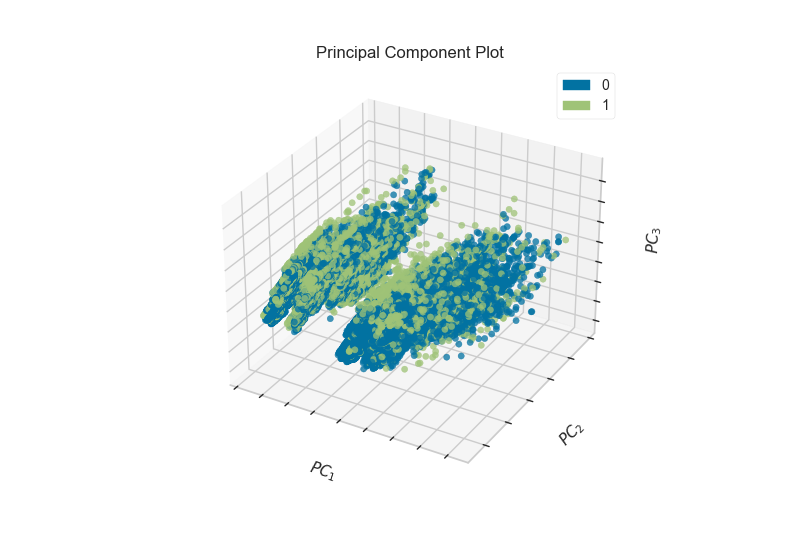

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [6]:
from yellowbrick.features import PCA
visualizer = PCA(scale=True, projection=3)
visualizer.fit_transform(X_train_scaled, y_train)
visualizer.show()

Bei dem Datensatz könnte 18 Komponenten 95% der Varianz erklären. Für eine Beschleunigung des Trainings wird daher auch diese Möglichkeit getestet.

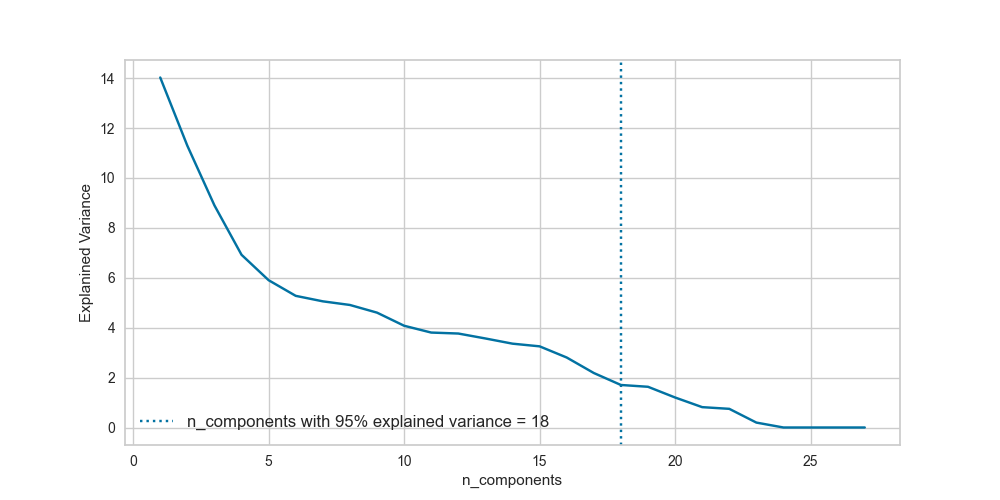

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_scaled)
n_95=np.argmax(np.cumsum(pca.explained_variance_ratio_ *100) >= 95)+1 #n_component with 95% explained variance 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(1, pca.n_components_ + 1),pca.explained_variance_ratio_*100)
ax.axvline(
    np.argmax(np.cumsum(pca.explained_variance_ratio_ *100) >= 95)+1,
    linestyle=":",
    label=f"n_components with 95% explained variance = {n_95}",
)
ax.set_ylabel("Explanined Variance")
ax.set_xlabel("n_components")
ax.legend(prop=dict(size=12))

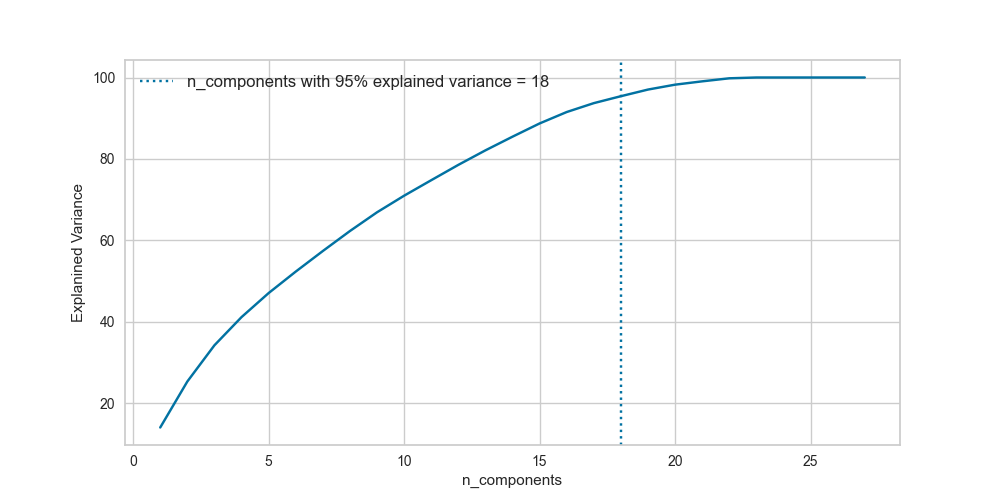

In [8]:
from sklearn.decomposition import PCA
n_95=np.argmax(np.cumsum(pca.explained_variance_ratio_ * 100) >= 95)+1 #n component with 95% explained variance 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_ *100)) #kumulierte summe der erklärten variance
ax.axvline(
    n_95,
    linestyle=":",
    label=f"n_components with 95% explained variance = {n_95}",
)
ax.set_ylabel("Explanined Variance")
ax.set_xlabel("n_components")
ax.legend(prop=dict(size=12))


In [9]:
np.cumsum(pca.explained_variance_ratio_ *100)

array([ 14.02510954,  25.31755165,  34.21878523,  41.1401201 ,
        47.04253176,  52.31806634,  57.37368353,  62.28381825,
        66.88658146,  70.96414544,  74.76844768,  78.5338551 ,
        82.10141527,  85.46073111,  88.71292794,  91.51769266,
        93.70156603,  95.40560888,  97.03726764,  98.23967012,
        99.05540099,  99.80322685, 100.        , 100.        ,
       100.        , 100.        , 100.        ])

X_reduced: 18 Komponenten

In [10]:
# reduced featured space to 18 with PCA
pca2 = PCA(n_components=0.95)
pca2.fit(X_train_scaled) # only fit to train data
X_train_reduced = pca2.transform(X_train_scaled)
X_test_reduced = pca2.transform(X_test_scaled)
X_train_reduced.shape

(66899, 18)

5. Training mit Accuracy: An dieser Stelle werden die einzelnen Kernel mit ihren standard Parameter und in Zusammenhang mit den Featureraum X_scaled und X_reduced verglichen.

RBF Kernel: Durch X_reduced wird das Training besser und schneller.

In [11]:
svm_rbf = SVC(class_weight="balanced") # rbf kernel
scores = cross_val_score(svm_rbf, X_train_scaled, y_train, cv=10, n_jobs=-1)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.73 accuracy with a standard deviation of 0.01


In [12]:
scores = cross_val_score(svm_rbf, X_train_reduced, y_train, cv=10, n_jobs=-1)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.73 accuracy with a standard deviation of 0.01


Linear Kernel: Dieser ist am schnellsten von allen Kernel. Hat allerdings eine schlechtere Genauigkeit.

In [13]:
svm_linear = LinearSVC(loss="hinge", class_weight="balanced")
scores = cross_val_score(svm_linear, X_train_scaled, y_train, cv=10, n_jobs=-1)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.69 accuracy with a standard deviation of 0.02


In [14]:
scores = cross_val_score(svm_linear, X_train_reduced, y_train, cv=10, n_jobs=-1)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.68 accuracy with a standard deviation of 0.01


Poly Kernel: Die Accuracy ist ähnlich mit rbf. X_reduced bringt keine bessere Trainingszeit.

In [15]:
svm_poly = SVC(kernel="poly", class_weight="balanced")
scores = cross_val_score(svm_poly, X_train_scaled, y_train, cv=10, n_jobs=-1)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.72 accuracy with a standard deviation of 0.01


In [16]:
scores = cross_val_score(svm_poly, X_train_reduced, y_train, cv=10, n_jobs=-1)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.72 accuracy with a standard deviation of 0.01


Gegeben der Trainingszeit, Genauigkeit und der Visualierung der Daten wird der rbf Kernel für die Optimierung der Hyperparameter gewählt.

In [17]:
#SVM hyper params opti
from sklearn.model_selection import GridSearchCV

    # Set the parameters by cross-validation
    #  Smaller C value, large margin violations.
    #  Larger C value, fewer margin violations.
    # The same for gamma and degree

parameters = [
        {
            'kernel': ['rbf'],
            'gamma': [5, 10, 20],
            'C': [10, 50, 100]
         }
    ]

grid = GridSearchCV(
        SVC(class_weight="balanced"), parameters, scoring='accuracy', cv=5, n_jobs=-1, verbose=10
    )

# print(clf.get_params().keys())
grid.fit(X_train_reduced, y_train)

print("Best parameters set found on X_train:")
print()
print(grid.best_params_)
print()
print("Grid scores on train_set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
      
print("Detailed classification report on X_test:")
print()
print()
y_true, y_pred = y_test, grid.predict(X_test_reduced)
print(classification_report(y_true, y_pred))
print()

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters set found on X_train:

{'C': 50, 'gamma': 5, 'kernel': 'rbf'}

Grid scores on train_set:

0.783 (+/-0.003) for {'C': 10, 'gamma': 5, 'kernel': 'rbf'}
0.775 (+/-0.003) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.775 (+/-0.002) for {'C': 10, 'gamma': 20, 'kernel': 'rbf'}
0.783 (+/-0.003) for {'C': 50, 'gamma': 5, 'kernel': 'rbf'}
0.775 (+/-0.003) for {'C': 50, 'gamma': 10, 'kernel': 'rbf'}
0.775 (+/-0.002) for {'C': 50, 'gamma': 20, 'kernel': 'rbf'}
0.783 (+/-0.003) for {'C': 100, 'gamma': 5, 'kernel': 'rbf'}
0.775 (+/-0.003) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
0.775 (+/-0.002) for {'C': 100, 'gamma': 20, 'kernel': 'rbf'}
Detailed classification report on X_test:


              precision    recall  f1-score   support

           0       0.81      0.96      0.87     12981
           1       0.57      0.20      0.29      3744

    accuracy                           0.79     16725
   macro avg       0.69

In [18]:
#SVM hyper params opti
from sklearn.model_selection import GridSearchCV

    # Set the parameters by cross-validation
    # Small Weight: Smaller C value, large margin violations.
    # Larger Weight: Larger C value, fewer margin violations.
    # The same for gamma and degree

parameters = [
        {
            'kernel': ['rbf'],
            'gamma': [0.01 ,0.1, 3],
            'C': [0.1, 1, 5]
         }
    ]

grid = GridSearchCV(
        SVC(class_weight="balanced"), parameters, scoring='accuracy', cv=5, n_jobs=-1, verbose=10
    )

# print(clf.get_params().keys())
grid.fit(X_train_reduced, y_train)

print("Best parameters set found on X_train:")
print()
print(grid.best_params_)
print()
print("Grid scores on train_set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
      
print("Detailed classification report on X_test:")
print()
print()
y_true, y_pred = y_test, grid.predict(X_test_reduced)
print(classification_report(y_true, y_pred))
print()

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters set found on X_train:

{'C': 5, 'gamma': 3, 'kernel': 'rbf'}

Grid scores on train_set:

0.692 (+/-0.004) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.701 (+/-0.009) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.778 (+/-0.011) for {'C': 0.1, 'gamma': 3, 'kernel': 'rbf'}
0.698 (+/-0.005) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.749 (+/-0.008) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.783 (+/-0.003) for {'C': 1, 'gamma': 3, 'kernel': 'rbf'}
0.716 (+/-0.006) for {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
0.775 (+/-0.010) for {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
0.787 (+/-0.005) for {'C': 5, 'gamma': 3, 'kernel': 'rbf'}
Detailed classification report on X_test:


              precision    recall  f1-score   support

           0       0.82      0.93      0.87     12981
           1       0.56      0.30      0.39      3744

    accuracy                           0.79     16725
   macro avg       0.

6. Training mit monetäres Maß

In [19]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                    bool

def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price'] = df['Price'] * 100
    df['Price'] = df['Price'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == 1):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100

In [20]:
X = customFeaturesDf.iloc[:,0:-1]
y = customFeaturesDf.iloc[:,-1]
scaler = StandardScaler(with_mean=False)

# scale variance to 1
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [21]:
pca2 = PCA(n_components=0.95)
pca2.fit(X_scaled)
X_reduced=pca2.transform(X_scaled)
X_reduced.shape

(83624, 18)

Training mit Standard Parameter

In [22]:
clf = SVC(class_weight="balanced")

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
money_scores = []

# for each fold create a dataframe
for train_index, test_index in skf.split(X_reduced, y): # split() return index of each fold
	# get each fold train, test fold with index index 
	x_train_fold, x_test_fold = X_reduced[train_index], X_reduced[test_index]
	y_train_fold, y_test_fold = y[train_index], y[test_index]
	clf.fit(x_train_fold, y_train_fold)
	y_pred = clf.predict(x_test_fold)
	
	# make test df to evaluate
	X_train_1 = train_set_or.loc[test_index]
	df = pd.DataFrame(x_test_fold, index=test_index)
	df["buy"] = y_pred
	df["flight_unique_id"] = X_train_1["flight_unique_id"]
	df["Request_Date"] = X_train_1["Request_Date"]
	df["Price"] = X_train_1["Price_In_Eur"]
 
	# eval with custom func and append
	score = model_quality_evaluation(df)
	money_scores.append(score)


# Print the output.
print('List of possible money scores:', money_scores)
print('\nMean Money:',
	np.mean(money_scores))
print('\nStandard Deviation is:', np.std(money_scores))

C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pand

List of possible money scores: [-32244.92, -5856.45, -13841.59, -18282.48, -19190.87]

Mean Money: -17883.261999999995

Standard Deviation is: 8591.92357555722


Hyperparameter Optimierung

In [23]:
combinations = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
            'kernel': ['rbf'],
            'gamma': [0.1, 1, 100],
            'C': [0.1, 1, 100]
}

for param in itertools.product(
    params["kernel"], params["gamma"], params["C"]
):
    clf = SVC(
        kernel=param[0],
        C=param[2],
        gamma=param[1],
        class_weight="balanced"
    )
    money_scores = []
    # for each fold create a dataframe
    # for each fold create a dataframe
    for train_index, test_index in skf.split(X_reduced, y): # split() return index of each fold
        # get each fold train, test fold with index index 
        x_train_fold, x_test_fold = X_reduced[train_index], X_reduced[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        y_pred = clf.predict(x_test_fold)
        
        # make test df to evaluate
        X_train_1 = train_set_or.loc[test_index]
        df = pd.DataFrame(x_test_fold, index=test_index)
        df["buy"] = y_pred
        df["flight_unique_id"] = X_train_1["flight_unique_id"]
        df["Request_Date"] = X_train_1["Request_Date"]
        df["Price"] = X_train_1["Price_In_Eur"]
    
        # eval with custom func and append
        score = model_quality_evaluation(df)
        money_scores.append(score)


    combinations[",".join(str(x) for x in param)] = money_scores

C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pand

In [24]:
first = True
maxMoney = 0
minMoney = 0
maxParam = ""
allMoney = []
for key, value in combinations.items():
  allMoney.extend(value)
  if first:
    maxMoney = max(value)
    minMoney = min(value)
    moneyParam = key
    first = False
  if max(value) > maxMoney:
    maxMoney = max(value)
    maxParam = key
  if min(value) < minMoney:
    minMoney = min(value)

# Print the output.
print("Maximum Money That can be obtained from this model is:", maxMoney)
print("\nMinimum Money:", minMoney)
print("\nOverall Money:", np.mean(allMoney))
print("\nStandard Deviation is:", np.std(allMoney))
print("\nParams for Maximum Money:", maxParam, "(kernel, gamma, c)")
print("\nAll combinations:", combinations)
print("\nList of possible money values:", allMoney)

Maximum Money That can be obtained from this model is: 0.0

Minimum Money: -818616.64

Overall Money: -262425.1346666667

Standard Deviation is: 323649.076607188

Params for Maximum Money: rbf,100,0.1 (kernel, gamma, c)

All combinations: {'rbf,0.1,0.1': [-63191.32, -50416.37, -55878.12, -83234.03, -65884.24], 'rbf,0.1,1': [-24914.27, -13211.71, -6299.63, -19264.42, -21880.54], 'rbf,0.1,100': [-20949.47, -18888.18, -15549.54, -10306.08, -8310.94], 'rbf,1,0.1': [-122870.19, -92616.66, -127784.65, -105141.01, -122935.47], 'rbf,1,1': [-93576.49, -104718.13, -101418.21, -101988.33, -84589.61], 'rbf,1,100': [-130898.67, -153870.07, -157707.98, -157507.97, -151462.12], 'rbf,100,0.1': [0.0, 0.0, 0.0, -818616.64, -803607.34], 'rbf,100,1': [-748179.85, -783488.38, -810979.36, -809885.57, -797288.17], 'rbf,100,100': [-748179.85, -783488.38, -810979.36, -809885.57, -797288.17]}

List of possible money values: [-63191.32, -50416.37, -55878.12, -83234.03, -65884.24, -24914.27, -13211.71, -6299.63, 

In [27]:
clf = SVC(class_weight="balanced", C=0.01, gamma=100, kernel="rbf")

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
money_scores = []

# for each fold create a dataframe
for train_index, test_index in skf.split(X_reduced, y): # split() return index of each fold
	# get each fold train, test fold with index index 
	x_train_fold, x_test_fold = X_reduced[train_index], X_reduced[test_index]
	y_train_fold, y_test_fold = y[train_index], y[test_index]
	clf.fit(x_train_fold, y_train_fold)
	y_pred = clf.predict(x_test_fold)
	
	# make test df to evaluate
	X_train_1 = train_set_or.loc[test_index]
	df = pd.DataFrame(x_test_fold, index=test_index)
	df["buy"] = y_pred
	df["flight_unique_id"] = X_train_1["flight_unique_id"]
	df["Request_Date"] = X_train_1["Request_Date"]
	df["Price"] = X_train_1["Price_In_Eur"]
 
	# eval with custom func and append
	score = model_quality_evaluation(df)
	money_scores.append(score)


# Print the output.
print('List of possible money scores:', money_scores)
print('\nMean Money:',
	np.mean(money_scores))
print('\nStandard Deviation is:', np.std(money_scores))

C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\Hung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pand

List of possible money scores: [-753056.47, -791532.89, -813918.41, -818616.64, 0.0]

Mean Money: -635424.882

Standard Deviation is: 318556.3815273086
